In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import norm
from scipy.stats import bernoulli
# import imageio
import random
from os import path as path
# from itertools import islice
import time

A function to obtain the evidence threshold for making a decision, given beliefs about thetas and a temporal discounting factor. 

In [2]:
T = 100 # number of simulated time steps

def get_threshold_asym(thetas,gamma):
    # thetas are the probabilities of obtaining a 1 in target absence and presence.
    # gamma is the discounting factor
    
    # V is value
    V=np.full([T*2+1, T*2+1],np.nan);

    # A is action
    A=np.full([T*2+1, T*2+1],np.nan);

    # LLR is LLR
    LLR=np.full([T*2+1, T*2+1],np.nan);
    
    for t in range(T*2, -1, -1):
        states= np.array(range(t+1)); # number of 1's
        LLR_at_t= states*(np.log(thetas[1])- np.log(thetas[0])) + \
        (t-states)*(np.log(1-thetas[1])- np.log(1-thetas[0]));
        
        LLR[t,states]= LLR_at_t;
        
        #to avoid overflow errors
        clipped_LLR_at_t = np.clip(LLR_at_t,-500,500)

        P_present= 1/(1+np.exp(-clipped_LLR_at_t));
        
        # value if I make a decision now
        V_choose_now= np.maximum(P_present,1-P_present)
        
        if t==T*2:
            V[t, states]= V_choose_now;
            # action is 1 for choosing 'present', -1 for choosing 'absent', and 0 otherwise
            A[t,states]= np.where(LLR_at_t>0,1,-1);
            
        else:
            # calculate value if waiting
            # the probability of obtaining a 1, marginalized over target presence and absence
            prob1= P_present*thetas[1]+ (1-P_present)*thetas[0];
            V_wait= gamma*(prob1*V[t+1,states+1]+ (1-prob1)*V[t+1,states]);
            
            V[t,states] = np.maximum(V_choose_now,V_wait)
            A[t,states] = np.where(V_choose_now>V_wait,1,0) * np.where(LLR_at_t>0,1,-1)

    half_A = A[:-T]
    half_LLR = LLR[:-T]
    
    LLR_no = half_LLR[half_A==-1]
    LLR_yes = half_LLR[half_A==1]

    return([np.max(LLR_no),np.min(LLR_yes)])


Simulate_forward_asym simulates behaviour (decisions, RT and confidence) given true thetas, beliefs about thetas, and gamma. The function calls a recursive function (extend chain) which continues the evidence accumulation process until the probability of reaching a node is negligible. 

In [20]:
T = 100 # number of simulated time steps

def simulate_forward_asym(true_thetas, believed_thetas, gamma):
    
    # V is value
    V=np.full([T*2+1, T*2+1],np.nan);

    # A is action
    A=np.full([T*2+1, T*2+1],np.nan);

    # LLR is LLR
    LLR=np.full([T*2+1, T*2+1],np.nan);
    
    for t in range(T*2, -1, -1):
        states= np.array(range(t+1)); # number of 1's
        LLR_at_t= states*(np.log(believed_thetas[1])- np.log(believed_thetas[0])) + \
        (t-states)*(np.log(1-believed_thetas[1])- np.log(1-believed_thetas[0]));
        
        LLR[t,states]= LLR_at_t;
        
        #to avoid overflow errors
        clipped_LLR_at_t = np.clip(LLR_at_t,-500,500)

        P_present= 1/(1+np.exp(-clipped_LLR_at_t));
        
        # value if I make a decision now
        V_choose_now= np.maximum(P_present,1-P_present)
        
        if t==T*2:
            V[t, states]= V_choose_now;
            # action is 1 for choosing 'present', -1 for choosing 'absent', and 0 otherwise
            A[t,states]= np.where(LLR_at_t>0,1,-1);
            
        else:
            # calculate value if waiting
            # the probability of obtaining a 1, marginalized over target presence and absence
            prob1= P_present*believed_thetas[1]+ (1-P_present)*believed_thetas[0];
            V_wait= gamma*(prob1*V[t+1,states+1]+ (1-prob1)*V[t+1,states]);
            
            V[t,states] = np.maximum(V_choose_now,V_wait)
            A[t,states] = np.where(V_choose_now>V_wait,1,0) * np.where(LLR_at_t>0,1,-1)

    half_A = A[:-T]
    half_LLR = LLR[:-T]
    
    LLR_no = half_LLR[half_A==-1]
    LLR_yes = half_LLR[half_A==1]

    threshold=[np.max(LLR_no),np.min(LLR_yes)]
    
    # now run forward
    df = pd.DataFrame(columns=['present','p','decision','RT','confidence'])

    #target absence
    prob=np.full([T+1, T+1],0.0);
    prob[0,0]=1
    for t in np.arange(0,T):
        for state in np.arange(0,t+1):
            if prob[t,state]==0:
                continue
            else:
                if LLR[t,state]>=threshold[1]:
                    df.loc[len(df)] = [0, 
                    prob[t,state],
                    1,
                    t,
                    np.exp(LLR[t,state])/(1+np.exp(LLR[t,state]))]
                elif LLR[t,state]<=threshold[0]:
                    df.loc[len(df)] = [0, 
                    prob[t,state],
                    0,
                    t,
                    1/(1+np.exp(LLR[t,state]))]
                else:
                    prob[t+1,state] += prob[t,state]*(1-true_thetas[0])
                    prob[t+1,state+1] += prob[t,state]*true_thetas[0]
   
    #target presence
    prob=np.full([T+1, T+1],0.0);
    prob[0,0]=1
    for t in np.arange(0,T):
        for state in np.arange(0,t+1):
            if prob[t,state]==0:
                continue
            else:
                if LLR[t,state]>=threshold[1]:
                    df.loc[len(df)] = [1, 
                    prob[t,state],
                    1,
                    t,
                    np.exp(LLR[t,state])/(1+np.exp(LLR[t,state]))]
                elif LLR[t,state]<=threshold[0]:
                    df.loc[len(df)] = [1, 
                    prob[t,state],
                    0,
                    t,
                    1/(1+np.exp(LLR[t,state]))]
                else:
                    prob[t+1,state] += prob[t,state]*(1-true_thetas[1])
                    prob[t+1,state+1] += prob[t,state]*true_thetas[1]
        
    return(df)

In [22]:
start = time.time()

RT_diff_df = pd.DataFrame(columns=['theta0','theta1','RTdiff'])
conf_diff_df = pd.DataFrame(columns=['theta0','theta1','confDiff'])
acc_df = pd.DataFrame(columns=['theta0','theta1','acc'])
bias_df = pd.DataFrame(columns=['theta0','theta1','bias'])

# theta_values = np.array([0.05,0.1,0.15,0.2])
theta_values = np.concatenate((np.array([0.01]),np.arange(0.05,0.51,0.05)))

#python is sometimes giving me .99999999999999 for some reason
theta_values = [round(theta*100)/100 for theta in theta_values]

for theta0 in theta_values:
    print(theta0)
    for theta1 in theta_values:
        if theta0<theta1:
            df = simulate_forward_asym([theta0,theta1],[theta0,theta1],0.99)
           
            mean_RT_diff = (df[df['present'] == df['decision']]
              .assign(p_scaled=lambda x: x.groupby('present')['p'].transform(lambda p: p / p.sum()))
              .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
              .groupby('present')['weighted_RT']
              .sum()
              .pipe(lambda x: x.get(1, 0) - x.get(0, 0)))
           
            RT_diff_df.loc[len(RT_diff_df)] = [theta0,
                               theta1,
                                mean_RT_diff]
           
            mean_conf_diff = (df[df['present'] == df['decision']]
                 .assign(p_scaled=lambda x: x.groupby('present')['p'].transform(lambda p: p / p.sum()))
                 .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
                 .groupby('present')['weighted_confidence']
                 .sum()
                 .pipe(lambda x: x.get(1) - x.get(0)))
           
            conf_diff_df.loc[len(conf_diff_df)] = [theta0,
                               theta1,
                                mean_conf_diff]
           
            acc = (df
            .assign(correct=lambda x: x['present'] == x['decision'])
            .assign(p_scaled=lambda x: x['p'].transform(lambda p: p / p.sum()))
            .assign(weighted_correct=lambda x: x['correct'] * x['p_scaled'])
            ['weighted_correct']
            .sum())
           
            acc_df.loc[len(conf_diff_df)] = [theta0,
                               theta1,
                                acc]
           
            bias = (df
            .assign(p_scaled=lambda x: x['p'].transform(lambda p: p / p.sum()))
            .assign(bias=lambda x: x['decision'] * x['p_scaled'])
            ['bias']
            .sum())
           
            bias_df.loc[len(conf_diff_df)] = [theta0,
                               theta1,
                                bias]
            
end = time.time()
print(end-start)

0.01
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
19.245113134384155


Estimating the expected RT and confidence differences between decisions about presence and absence as a function of theta.

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/1259558005.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = RT_diff_df.pivot("theta0", "theta1", "RTdiff")


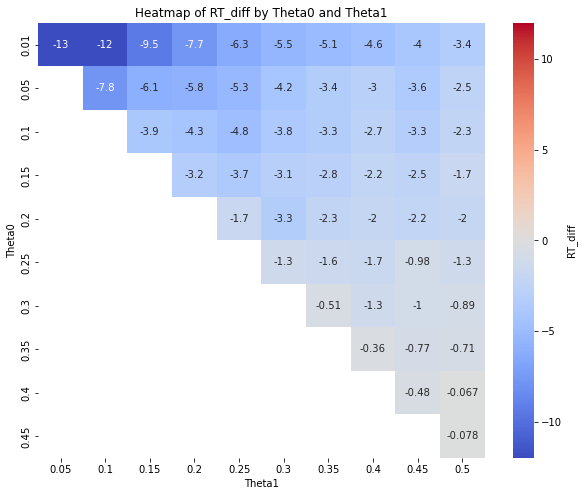

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/1259558005.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = conf_diff_df.pivot("theta0", "theta1", "confDiff")


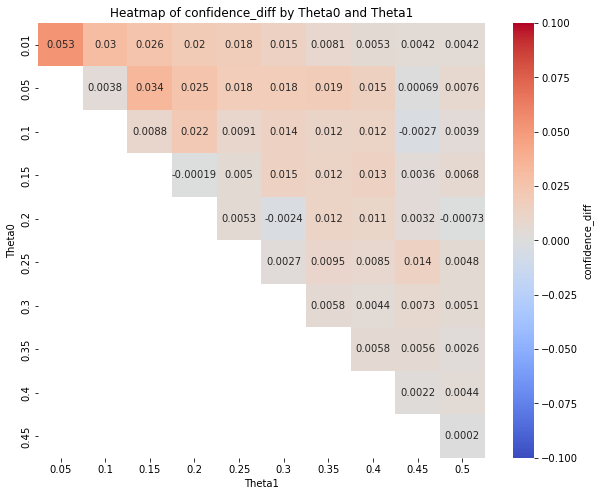

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/1259558005.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = acc_df.pivot("theta0", "theta1", "acc")


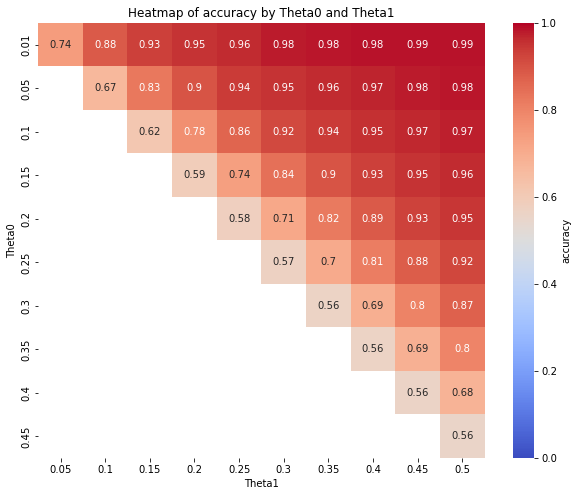

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/1259558005.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = bias_df.pivot("theta0", "theta1", "bias")


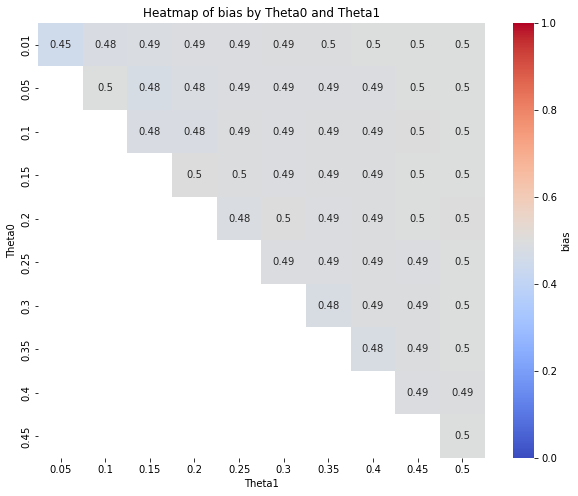

In [23]:
pivot_df = RT_diff_df.pivot("theta0", "theta1", "RTdiff")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'RT_diff'}, center=0, vmin=-12, vmax=12)
plt.title('Heatmap of RT_diff by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

pivot_df = conf_diff_df.pivot("theta0", "theta1", "confDiff")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'confidence_diff'}, center=0, vmin=-0.1, vmax=0.1)
plt.title('Heatmap of confidence_diff by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

pivot_df = acc_df.pivot("theta0", "theta1", "acc")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'accuracy'}, vmin=0, vmax=1)
plt.title('Heatmap of accuracy by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

pivot_df = bias_df.pivot("theta0", "theta1", "bias")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'bias'}, center=0.5, vmin=0, vmax=1)
plt.title('Heatmap of bias by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

Next, we simulate the effects of beliefs about alpha on RT, confidence, and guessing rates, for the same true alphas. We simulate the two conditions as [0.05, 0.15] and 0.7*[0.05,0.15] and the alphas as pairs of values averaging around 0.85, from [0.85,0.85] to [1.15,0.55].

In [24]:
big_df = pd.DataFrame()

true_alpha_values = [1,0.7]
alpha_prime_pairs = [[round((1-x)*100)/100,round((0.7+x)*100)/100] for x in np.arange(-0.2,0.16,0.01)]

theta0 = 0.05
theta1 = 0.15

for believed_alpha_values in alpha_prime_pairs:

    df_easy = simulate_forward_asym(true_alpha_values[0]*np.array([theta0,theta1]),
                                    believed_alpha_values[0]*np.array([theta0,theta1]),0.99)
    
    df_hard = simulate_forward_asym(true_alpha_values[1]*np.array([theta0,theta1]),
                                    believed_alpha_values[1]*np.array([theta0,theta1]),0.99)
    
    df_easy['condition'] = 'easy'
    df_hard['condition'] = 'hard'
    df_merged = pd.concat([df_easy,df_hard])
    df_merged['alpha_prime_easy'] = believed_alpha_values[0]
    df_merged['alpha_prime_hard'] = believed_alpha_values[1]
    df_merged['alpha_easy'] = true_alpha_values[0]
    df_merged['alpha_hard'] = true_alpha_values[1]
    
    big_df = pd.concat([big_df,df_merged])


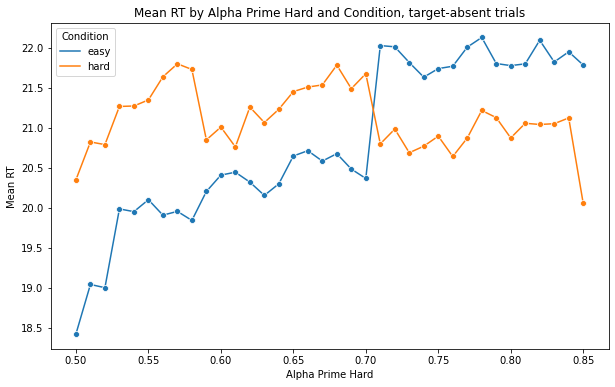

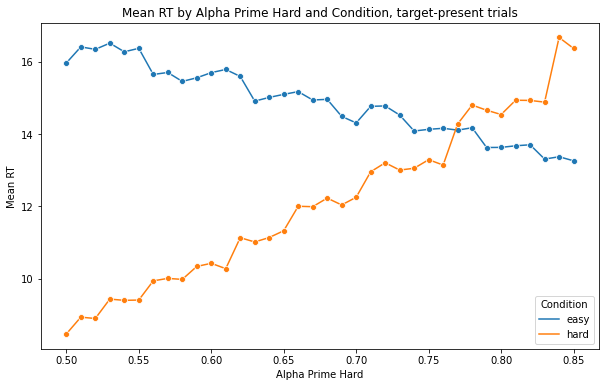

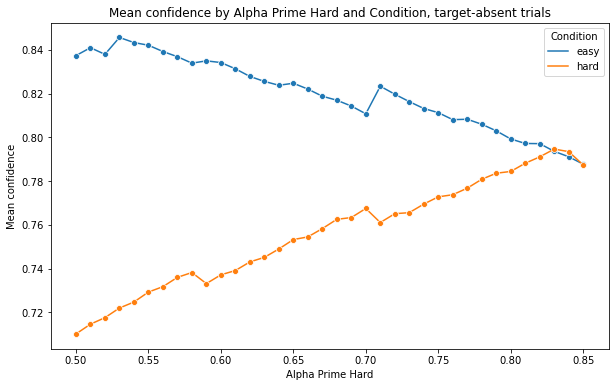

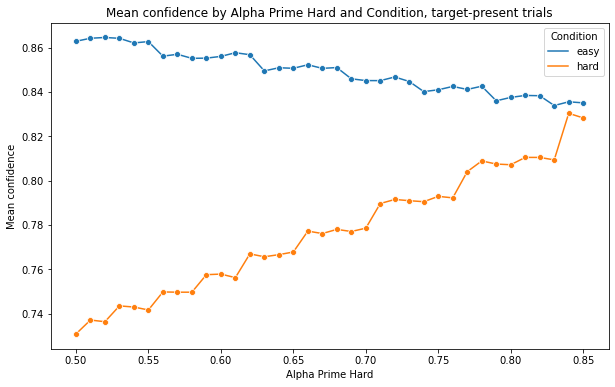

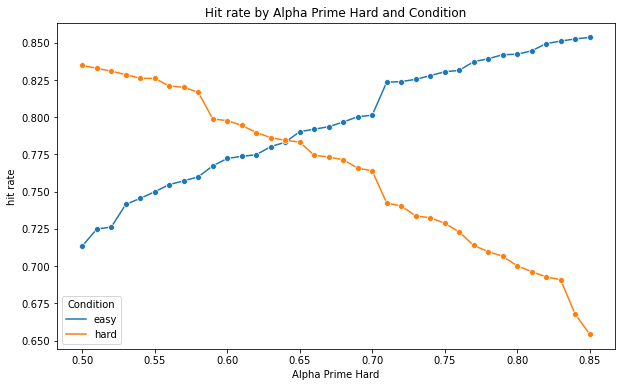

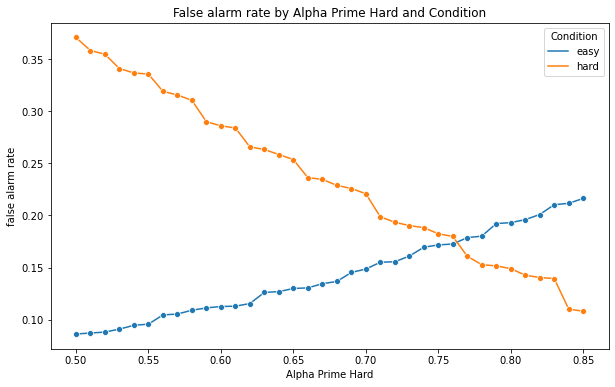

In [25]:
RT_absent = (big_df[(big_df['decision'] == 0) & (big_df['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_RT']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=RT_absent, x='alpha_prime_hard', y='weighted_RT', hue='condition', marker='o')

plt.title('Mean RT by Alpha Prime Hard and Condition, target-absent trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean RT')
plt.legend(title='Condition')
plt.show()

RT_present = (big_df[(big_df['decision'] == 1) & (big_df['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_RT']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=RT_present, x='alpha_prime_hard', y='weighted_RT', hue='condition', marker='o')

plt.title('Mean RT by Alpha Prime Hard and Condition, target-present trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean RT')
plt.legend(title='Condition')
plt.show()

confidence_absent = (big_df[(big_df['decision'] == 0) & (big_df['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_confidence']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=confidence_absent, x='alpha_prime_hard', y='weighted_confidence', hue='condition', marker='o')

plt.title('Mean confidence by Alpha Prime Hard and Condition, target-absent trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean confidence')
plt.legend(title='Condition')
plt.show()

confidence_present = (big_df[(big_df['decision'] == 1) & (big_df['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_confidence']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=confidence_present, x='alpha_prime_hard', y='weighted_confidence', hue='condition', marker='o')

plt.title('Mean confidence by Alpha Prime Hard and Condition, target-present trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean confidence')
plt.legend(title='Condition')
plt.show()

hits = (big_df[(big_df['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_hits=lambda x: x['decision'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_hits']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=hits, x='alpha_prime_hard', y='weighted_hits', hue='condition', marker='o')

plt.title('Hit rate by Alpha Prime Hard and Condition')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('hit rate')
plt.legend(title='Condition')
plt.show()

false_alarms = (big_df[(big_df['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_fas=lambda x: x['decision'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_fas']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=false_alarms, x='alpha_prime_hard', y='weighted_fas', hue='condition', marker='o')

plt.title('False alarm rate by Alpha Prime Hard and Condition')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('false alarm rate')
plt.legend(title='Condition')
plt.show()

In [26]:
big_df_2 = pd.DataFrame()

true_alpha_values = [1,0.7]
alpha_prime_pairs = [[round((1-x)*100)/100,round((0.7+x)*100)/100] for x in np.arange(-0.2,0.16,0.02)]

theta0=0.01
theta1 = 0.1

for believed_alpha_values in alpha_prime_pairs:

    df_easy = simulate_forward_asym(true_alpha_values[0]*np.array([theta0,theta1]),
                                    believed_alpha_values[0]*np.array([theta0,theta1]),0.99)
    
    df_hard = simulate_forward_asym(true_alpha_values[1]*np.array([theta0,theta1]),
                                    believed_alpha_values[1]*np.array([theta0,theta1]),0.99)
    
    df_easy['condition'] = 'easy'
    df_hard['condition'] = 'hard'
    df_merged = pd.concat([df_easy,df_hard])
    df_merged['alpha_prime_easy'] = believed_alpha_values[0]
    df_merged['alpha_prime_hard'] = believed_alpha_values[1]
    df_merged['alpha_easy'] = true_alpha_values[0]
    df_merged['alpha_hard'] = true_alpha_values[1]
    
    big_df_2 = pd.concat([big_df_2,df_merged])


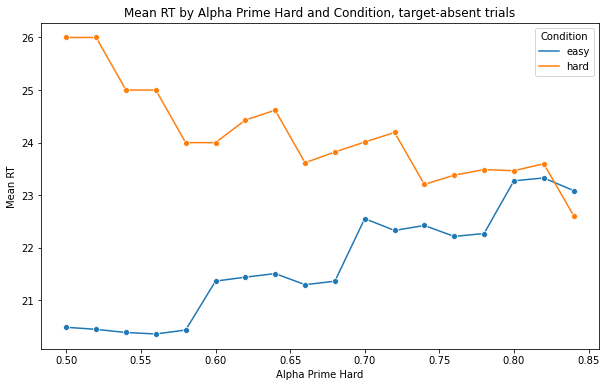

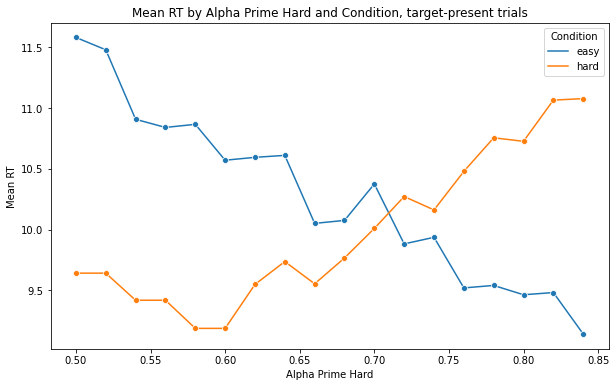

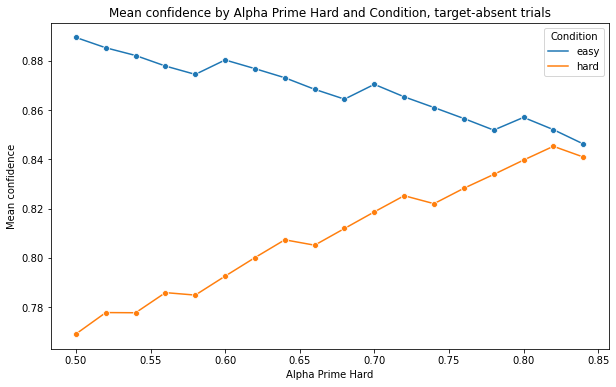

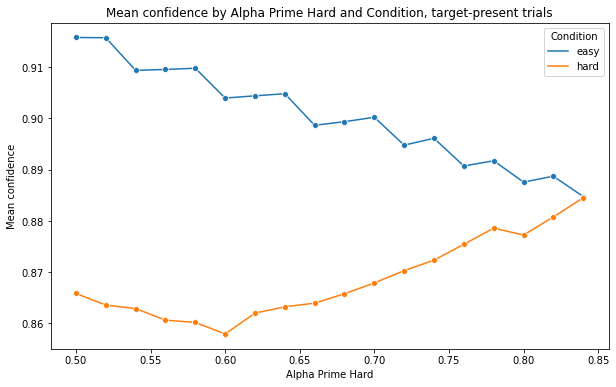

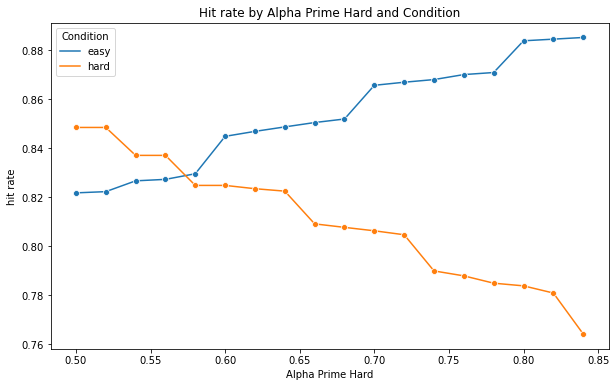

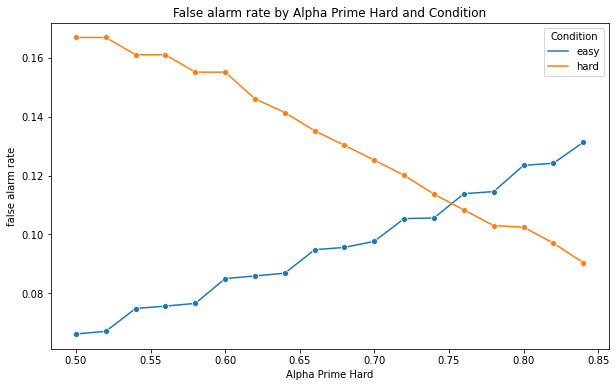

In [27]:
RT_absent = (big_df_2[(big_df_2['decision'] == 0) & (big_df_2['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_RT']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=RT_absent, x='alpha_prime_hard', y='weighted_RT', hue='condition', marker='o')

plt.title('Mean RT by Alpha Prime Hard and Condition, target-absent trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean RT')
plt.legend(title='Condition')
plt.show()

RT_present = (big_df_2[(big_df_2['decision'] == 1) & (big_df_2['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_RT']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=RT_present, x='alpha_prime_hard', y='weighted_RT', hue='condition', marker='o')

plt.title('Mean RT by Alpha Prime Hard and Condition, target-present trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean RT')
plt.legend(title='Condition')
plt.show()

confidence_absent = (big_df_2[(big_df_2['decision'] == 0) & (big_df_2['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_confidence']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=confidence_absent, x='alpha_prime_hard', y='weighted_confidence', hue='condition', marker='o')

plt.title('Mean confidence by Alpha Prime Hard and Condition, target-absent trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean confidence')
plt.legend(title='Condition')
plt.show()

confidence_present = (big_df_2[(big_df_2['decision'] == 1) & (big_df_2['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_confidence']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=confidence_present, x='alpha_prime_hard', y='weighted_confidence', hue='condition', marker='o')

plt.title('Mean confidence by Alpha Prime Hard and Condition, target-present trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean confidence')
plt.legend(title='Condition')
plt.show()

hits = (big_df_2[(big_df_2['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_hits=lambda x: x['decision'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_hits']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=hits, x='alpha_prime_hard', y='weighted_hits', hue='condition', marker='o')

plt.title('Hit rate by Alpha Prime Hard and Condition')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('hit rate')
plt.legend(title='Condition')
plt.show()

false_alarms = (big_df_2[(big_df_2['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_fas=lambda x: x['decision'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_fas']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=false_alarms, x='alpha_prime_hard', y='weighted_fas', hue='condition', marker='o')

plt.title('False alarm rate by Alpha Prime Hard and Condition')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('false alarm rate')
plt.legend(title='Condition')
plt.show()

In [ ]:
big_df_2